In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time
from sklearn.manifold import TSNE

In [34]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [35]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))


Data size 17005207


Build the dictionary and replace rare words with UNK token
* data : the index of word in dictionary
* count : word and word frequency
* vocabulary_size : top size of word frequency,the words would be instead of UNK whose frequency is less than size
* dictionary : word and word order in list
* reverse_dictionary : swap key and value of dicitonary

In [36]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

K-skip pf n-grams: here (k is skip_window) and (n is num_of_skips)

In [37]:
### data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  # put the word index into buffer
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    
    for j in range(num_skips):
      while target in targets_to_avoid:
        # if window locate the center word, assigh a random value (0, span - 1) to target
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:10]])

for num_skips, skip_window in [(1,1),(2, 1),(4,3), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=12, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(12)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 1 and skip_window = 1:
    batch: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class']
    labels: ['as', 'originated', 'as', 'a', 'abuse', 'of', 'used', 'against', 'early', 'working', 'class', 'radicals']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of', 'term', 'abuse', 'of', 'first']

with num_skips = 4 and skip_window = 3:
    batch: ['a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['anarchism', 'originated', 'abuse', 'term', 'first', 'as', 'abuse', 'a', 'first', 'a', 'as', 'abuse']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term

In [38]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.

skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()
# ['Assign','Variable']
temp=[]
def device_for_node(n):
  temp.append(n.type)
  if n.type in ['MatMul']:
    gpu_list = ["/gpu:0","/gpu:1"]
    gpu = random.choice(gpu_list)
    return gpu
  else:
    return "/cpu:0"
with graph.as_default():
    with graph.device(device_for_node):
      
      # Input data.
      train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
      train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
      valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Variables.
      embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / math.sqrt(embedding_size)))
      softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

      # Model.
      
      # Look up embeddings for inputs.
      embed = tf.nn.embedding_lookup(embeddings, train_dataset)
      # Compute the softmax loss, using a sample of the negative labels each time.
      loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

      # Optimizer.
      optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

      # Compute the similarity between minibatch examples and all embeddings.
      # We use the cosine distance:
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
      similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
      global temp
      print(list(set(temp)))

[u'Slice', u'Const', u'Sub', u'ExpandDims', u'Reshape', u'Sum', u'Sqrt', u'Add', u'BroadcastGradientArgs', u'SoftmaxCrossEntropyWithLogits', u'RandomUniform', u'Tile', u'Mul', u'Prod', u'TruncatedNormal', u'Log', u'SparseApplyAdagrad', u'Transpose', u'Shape', u'Reverse', u'Neg', u'Variable', u'AddN', u'Squeeze', u'Placeholder', u'DynamicStitch', u'Concat', u'LogUniformCandidateSampler', u'Mean', u'SparseToDense', u'Gather', u'Cast', u'Range', u'Div', u'ComputeAccidentalHits', u'Assign', u'Pack', u'Square', u'Rank', u'MatMul', u'NoOp', u'Identity', u'Pad', u'Fill']


In [39]:
# Create a summary to monitor cost function
tf.scalar_summary("loss", loss)

# Merge all summaries to a single operator
merged_summary_op = tf.merge_all_summaries()

In [40]:
num_steps = 100001
start = time.time()
with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as session:
  tf.initialize_all_variables().run()
 
  # Set logs writer into folder /tmp/tensorflow_logs
  summary_writer = tf.train.SummaryWriter('/home/wchen/tmp/tensorflow_logs', graph_def=session.graph_def)

  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
final = time.time()
print(final-start)

Initialized
Average loss at step 0: 8.097987
Nearest to all: wolfenstein, creating, lac, homogeneity, cade, squire, polyester, apteryx,
Nearest to years: moulin, conception, ibook, operation, frunze, jehoahaz, summary, kaaba,
Nearest to would: svenska, receding, maine, viceroy, justus, cnd, batsman, dx,
Nearest to th: doubts, anhydrous, servers, fright, paris, fluorine, bosnian, methionine,
Nearest to on: hillsides, tunic, ming, amulets, loaded, ussr, wealthy, oh,
Nearest to between: damage, endomorphisms, modesty, won, pane, permittivity, rennie, mohammad,
Nearest to first: reopened, racecourse, entrants, matrimonial, patched, redskins, assign, diverting,
Nearest to be: dieter, ciliates, cali, administrations, rhino, daiko, inexperience, janata,
Nearest to who: had, smuggler, cabbie, queries, carbonic, thrived, along, met,
Nearest to with: very, devlin, whit, swung, disrepair, alkanes, amanda, transitory,
Nearest to is: disallowed, linda, sculptured, dimensional, boer, originals, iter

## Run the command line
  tensorboard --logdir=/tmp/tensorflow_logs
## Open http://localhost:6006/ into your web browser

In [43]:
%matplotlib inline

In [44]:

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

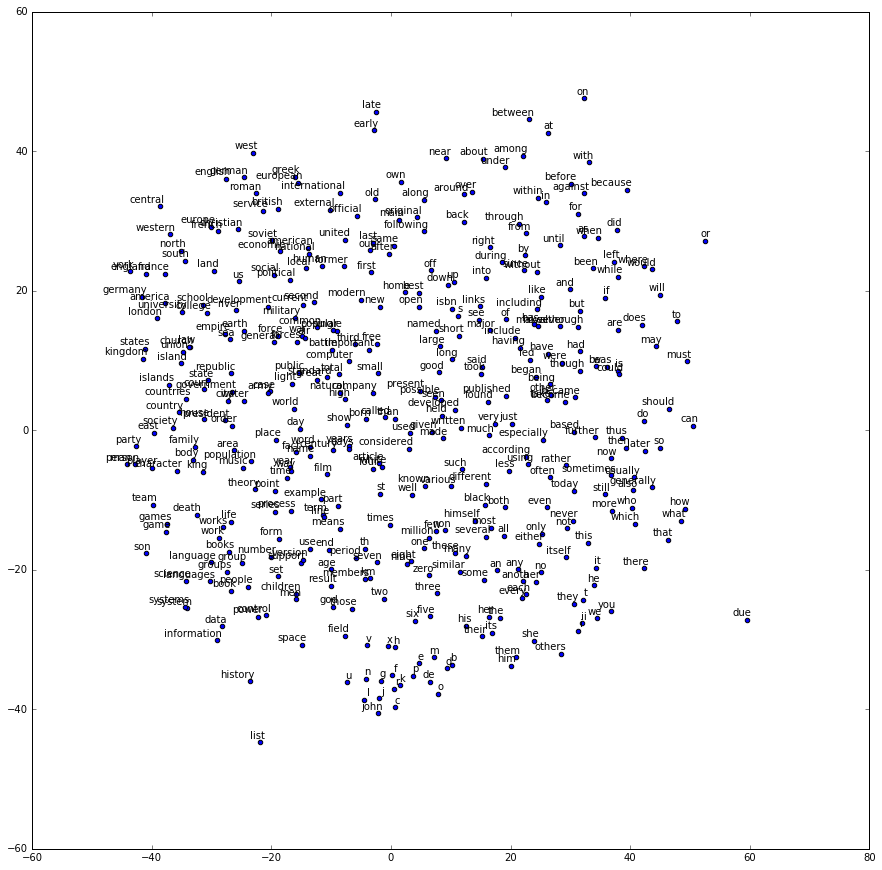

In [45]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)